<a href="https://colab.research.google.com/github/componavt/volcano_wikidata/blob/main/src/cluster_max_diameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clustering of Volcanoes and Earthquakes 🌋🌍

Алгоритм:
Во внешнем цикле меняется не максимальное расстояние между двумя элементами кластера, а максимальный разрешённый диаметр кластера.

In [9]:
# Input parameters
LANGUAGE = 'ru'  # 'en' or 'ru'

f_volcano = "volcanoes_2025.csv"
f_earthquake = "earthquakes_2025.csv"

# --- New clustering by max diameter ---
#cluster_diameter_max_list = list(range(10, 250, 10)) + [127]
#cluster_diameter_max_list = list(range(10, 120, 10)) + [127] + list(range(130, 250, 10))
distances_max_list = list(range(10, 30, 10)) + list(range(30, 120, 2)) + list(range(120, 180, 10))

# --- Distance thresholds to explore ---
# dist_max = 100  # maximum distance (km) between volcano and earthquake to draw a line

# distances_max_list = range(10, 250, 10)  # Test thresholds from 10 km to 250 km
# distances_max_list = range(30, 150, 10)
distances_max_list = list(range(30, 80, 10)) + list(range(80, 100, 1)) + list(range(100, 150, 10)) # slow real
# distances_max_list = list(range(30, 80, 20)) + list(range(80, 100, 5)) + list(range(100, 150, 20)) # fast

# шаг 10 для диапазона 80-170, но шаг 2 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 90, 100, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 140, 150, 160]
#distances_max_list = list(range(80, 120, 10)) + list(range(120, 130, 1)) + list(range(130, 170, 10))

# fast: шаг 40 для диапазона 80-170, но шаг 5 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 120, 127, 128, 130, 170]
#distances_max_list = list(range(80, 121, 40)) + [125] + list(range(127, 129, 1)) + list(range(130, 171, 40))
#distances_max_list = list(range(80, 121, 40))          + list(range(127, 129, 1)) + list(range(130, 171, 40))

print(distances_max_list)

[30, 40, 50, 60, 70, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 110, 120, 130, 140]


In [10]:
import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt
import folium
#from mpl_toolkits.axes_grid1 import host_subplot

#import mpl_toolkits.axisartist as AA
#from   mpl_toolkits.axisartist import Subplot as AA

from sklearn.metrics.pairwise import haversine_distances



# Download CSV files from GitHub
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_volcano
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_earthquake

#!head -n 3 $f_volcano
#!head -n 3 $f_earthquake

--2025-05-02 23:22:37--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/volcanoes_2025.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168392 (164K) [text/plain]
Saving to: ‘volcanoes_2025.csv.1’

volcanoes_2025.csv. 100%[===================>] 164.45K  --.-KB/s    in 0.03s   

2025-05-02 23:22:37 (4.68 MB/s) - ‘volcanoes_2025.csv.1’ saved [168392/168392]

--2025-05-02 23:22:37--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/earthquakes_2025.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

# 📏 Computing the Maximum Diameter of a Group

In [11]:
from geopy.distance import geodesic

def compute_group_diameter(group_coords):
    max_distance = 0
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
    return max_distance

Done in 0.78 sec | Groups:   22 | AvgSize:  3.32 | MaxSize:  24 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed:  22
Done in 0.64 sec | Groups:   69 | AvgSize:  3.94 | MaxSize:  52 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed:  69
Done in 0.73 sec | Groups:  105 | AvgSize:  3.99 | MaxSize:  52 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed: 105
Done in 0.62 sec | Groups:  143 | AvgSize:  4.20 | MaxSize:  54 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed: 143
Done in 0.62 sec | Groups:  177 | AvgSize:  4.12 | MaxSize:  62 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed: 177
Done in 0.65 sec | Groups:  212 | AvgSize:  4.19 | MaxSize:  64 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed: 212
Done in 0.72 sec | Groups:  244 | AvgSize:  4.20 | MaxSize:  64 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed: 244
Done in 0.68 sec | Groups:  278 | AvgSize:  4.15 | MaxSize:  64 | VolcanoOnly:   0 | EarthquakeOnly:   0 | Mixed: 278
Done in 0.60 sec | Groups:  320 | AvgSize:  4.11 | MaxSi

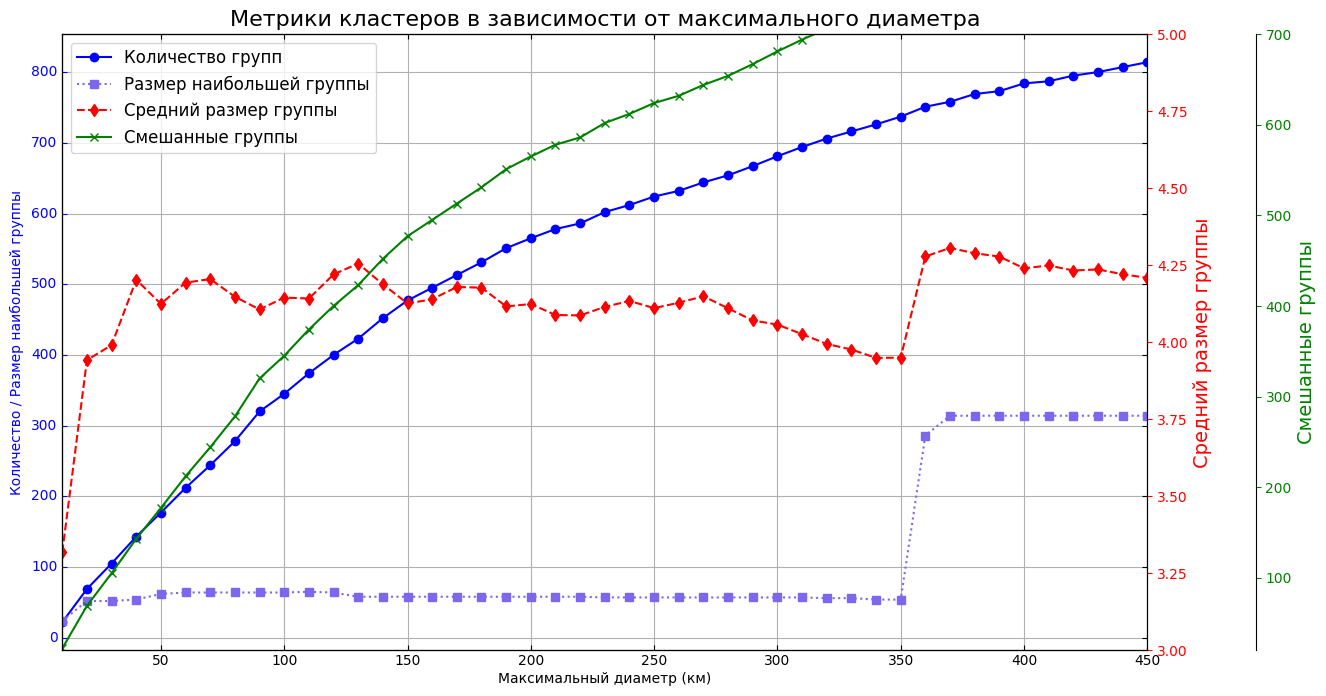

KeyboardInterrupt: 

In [12]:
# --- Language translation: 'en' or 'ru' ---
def tr(en_text: str, ru_text: str) -> str:
    """Simple translator function. Returns text based on current LANGUAGE setting."""
    return ru_text if LANGUAGE == 'ru' else en_text

# --- Load volcano and earthquake coordinates ---

def parse_coords(coord_string):
    lon, lat = map(float, coord_string.replace("Point(", "").replace(")", "").split())
    return (lat, lon)

volcano_coords = []
earthquake_coords = []

with open(f_volcano, encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        coord = parse_coords(row['location'])
        volcano_coords.append(coord)

with open(f_earthquake, encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        coord = parse_coords(row['location'])
        earthquake_coords.append(coord)

from sklearn.metrics.pairwise import haversine_distances as sklearn_haversine
from sklearn.neighbors import KDTree
from collections import defaultdict

import time

def haversine(p1, p2):
    lat1, lon1 = np.radians(p1)
    lat2, lon2 = np.radians(p2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * 6371 * np.arcsin(np.sqrt(a))

def compute_group_diameter(coords):
    if len(coords) < 2:
        return 0
    dist_matrix = sklearn_haversine(np.radians(coords)) * 6371.0
    return np.max(dist_matrix)

diameter_limits = list(range(10, 451, 10))
groups_count_list = []
average_group_size_list = []
largest_group_size_list = []
volcano_only_count = []
earthquake_only_count = []
mixed_group_count = []

all_clusters_by_d = {}

for d_max in diameter_limits:
    start_time = time.time()

    used_volcano = set()
    used_eq = set()
    pair_vol_eq = []
    pair_centres = []

    vol_tree = KDTree(np.radians(volcano_coords), metric='euclidean')
    eq_tree = KDTree(np.radians(earthquake_coords), metric='euclidean')

    radius_rad = d_max / 6371.0

    for vi, v_coord in enumerate(volcano_coords):
        if vi in used_volcano:
            continue
        eq_idxs = eq_tree.query_radius([np.radians(v_coord)], r=radius_rad)[0]
        for ei in eq_idxs:
            if ei in used_eq:
                continue
            used_volcano.add(vi)
            used_eq.add(ei)
            pair_vol_eq.append((vi, ei))
            center = (
                (volcano_coords[vi][0] + earthquake_coords[ei][0]) / 2,
                (volcano_coords[vi][1] + earthquake_coords[ei][1]) / 2
            )
            pair_centres.append(center)
            break

    pair_clusters = [set([vi, len(volcano_coords) + ei]) for vi, ei in pair_vol_eq]
    pair_centre_tree = KDTree(np.radians(pair_centres), metric='euclidean') if pair_centres else None

    others = set(range(len(volcano_coords) + len(earthquake_coords))) - set.union(*pair_clusters) if pair_clusters else set(range(len(volcano_coords) + len(earthquake_coords)))
    all_coords = volcano_coords + earthquake_coords
    types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)

    cluster_map = {i: cluster for i, cluster in enumerate(pair_clusters)}

    if pair_centre_tree:
        for o in others:
            o_coord = all_coords[o]
            dist, ind = pair_centre_tree.query([np.radians(o_coord)], k=1)
            if dist[0][0] < radius_rad:
                cluster_map[ind[0][0]].add(o)

    connected_components = list(cluster_map.values())
    all_clusters_by_d[d_max] = connected_components

    group_sizes = [len(group) for group in connected_components]
    groups_count_list.append(len(group_sizes))
    average_group_size_list.append(np.mean(group_sizes) if group_sizes else 0)
    largest_group_size_list.append(np.max(group_sizes) if group_sizes else 0)

    volcano_only = 0
    earthquake_only = 0
    mixed = 0

    for group in connected_components:
        group_types = set(types[idx] for idx in group)
        if group_types == {'volcano'}:
            volcano_only += 1
        elif group_types == {'earthquake'}:
            earthquake_only += 1
        else:
            mixed += 1

    volcano_only_count.append(volcano_only)
    earthquake_only_count.append(earthquake_only)
    mixed_group_count.append(mixed)

    print(f"Done in {time.time() - start_time:.2f} sec | Groups: {len(group_sizes):4d} | AvgSize: {average_group_size_list[-1]:5.2f} | MaxSize: {largest_group_size_list[-1]:3d} | VolcanoOnly: {volcano_only:3d} | EarthquakeOnly: {earthquake_only:3d} | Mixed: {mixed:3d}")

# --- Plot the results with right Y-axis for average group size and mixed ---

import mpl_toolkits.axisartist as AA
from mpl_toolkits.axisartist import Subplot as AA_Subplot

fig = plt.figure(figsize=(14, 8))
host = AA_Subplot(fig, 111)
fig.add_subplot(host)

par1 = host.twinx()  # Right Y-axis for average group size
par2 = host.twinx()  # Right Y-axis for mixed group count
par2.spines["right"].set_position(("axes", 1.1))

host.plot(diameter_limits, groups_count_list, marker='o', label=tr("Number of Groups", "Количество групп"), color='blue')
host.plot(diameter_limits, largest_group_size_list, marker='s', linestyle=':', label=tr("Largest Group Size", "Размер наибольшей группы"), color='mediumslateblue')
par1.plot(diameter_limits, average_group_size_list, marker='d', linestyle='--', label=tr("Average Group Size", "Средний размер группы"), color='red')
par2.plot(diameter_limits, mixed_group_count, marker='x', linestyle='-', label=tr("Mixed Groups", "Смешанные группы"), color='green')

host.set_xlabel(tr("Maximum Diameter (km)", "Максимальный диаметр (км)"), fontsize=14)
host.set_ylabel(tr("Group Count / Largest Size", "Количество / Размер наибольшей группы"), fontsize=14)
par1.set_ylabel(tr("Average Group Size", "Средний размер группы"), fontsize=14)
par2.set_ylabel(tr("Mixed Groups", "Смешанные группы"), fontsize=14)

host.axis["left"].label.set_color("blue")
host.axis["left"].major_ticks.set_color("blue")
host.axis["left"].major_ticklabels.set_color("blue")

par1.tick_params(axis='y', colors='red')
par1.yaxis.label.set_color("red")
par2.tick_params(axis='y', colors='green')
par2.yaxis.label.set_color("green")

par1.set_ylim(3, 5)
par2.set_ylim(20, 820)
host.set_xlim(min(diameter_limits), max(diameter_limits))

lines = host.get_lines() + par1.get_lines() + par2.get_lines()
labels = [line.get_label() for line in lines]
host.legend(lines, labels, loc="upper left", fontsize=12)

host.set_title(tr("Cluster Metrics vs Maximum Diameter", "Метрики кластеров в зависимости от максимального диаметра"), fontsize=16)
host.grid(True)
plt.show()

# --- Draw map for d_max = 90 ---

import folium
from folium import plugins

m = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB positron')

if 90 in all_clusters_by_d:
    for group in all_clusters_by_d[90]:
        group_coords = [volcano_coords[idx] if idx < len(volcano_coords) else earthquake_coords[idx - len(volcano_coords)] for idx in group]
        group_types = [types[idx] for idx in group]

        for idx, coord in zip(group, group_coords):
            folium.CircleMarker(location=coord,
                                radius=4,
                                color='red' if types[idx] == 'volcano' else 'black',
                                fill=True,
                                fill_opacity=1).add_to(m)

        for i in range(len(group)):
            for j in range(i + 1, len(group)):
              group_list = list(group)
              for i in range(len(group_list)):
                  for j in range(i + 1, len(group_list)):
                      if types[group_list[i]] != types[group_list[j]]:
                          is_mixed = True
                          folium.PolyLine([group_coords[i], group_coords[j]],
                                          color="gray",
                                          weight=1,
                                          opacity=0.5).add_to(m)
m